# Capstone Project: Milestone Report
### Vikash Patel

As a large grocery and goods retailer, it is always in your best interests to hold your inventory at optimal levels. Store managers look to reduce spoilage risk of over-stocking perishable goods, and also hope to avoid being out-of-stock of goods that are heavily demanded. These scenarios are stressed during times of severe weather, such as heavy rainfall or snowfall. Are the effects of weather large enough to change buying patterns of potentially weather sensitive goods (like milk, bread, umbrellas) at stores? Or are there other factors that are more influential to consumers when going to the store? In this case study, I will be testing to see if there is a relationship between sales of weather sensitive goods and weather, and will also be forecasting future sales using a predictive regression model. The aim of this case study is to help give store managers a better approach on handling inventory management during times of severe weather.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

raw_weather = pd.read_csv('data/weather.csv')
sales_train = pd.read_csv('data/train.csv')
key = pd.read_csv('data/key.csv')

In [2]:
raw_weather.head(3)

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0


In [3]:
sales_train.head(3)

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0


In [4]:
key.head(3)

,store_nbr,station_nbr
0,1,1
1,2,14
2,3,7


The datasets I am working with are very basic in detail. There is no key as to what item each item number corresponds to. Also, a disclaimer in the sales dataset noted that item numbers are not consistent for each store, meaning item 1 in store 1 may not be the same as item 1 in store 2. This prevents me from looking at overall item trends across different stores in relation to weather. I will have to conduct this analysis on a store by store basis. The key dataset is what describes the relationship between certain stores and their respective weather stations, and will be necessary for joining the sales and weather data together. Multiple stores will point to the same weather station. From the weather dataset, we will be utilizing the 'tavg' (average daily temperature) and 'preciptotal' (daily precipitation total) columns, as both are primary indicators of the weather. Conditions with recorded precipitation and average temperatures below 32 degrees F will be indicative of winter weather (freezing rain, sleet, snow).

In [5]:
weather_df = raw_weather[['date','station_nbr','tavg','preciptotal']]
replacements = {'tavg' : {r'M' : np.nan},
                'preciptotal' : {r'T' : 0.00, r'M' : np.nan}}
clean_weather = weather_df.replace(replacements, regex=True)
clean_weather.dropna(inplace=True)
clean_weather['tavg'] = clean_weather['tavg'].apply(pd.to_numeric)
clean_weather['preciptotal'] = clean_weather['preciptotal'].apply(pd.to_numeric)
clean_weather.head(3)

,date,station_nbr,tavg,preciptotal
0,2012-01-01,1,42,0.05
1,2012-01-01,2,41,0.07
2,2012-01-01,3,45,0.00


The cleaning transformations above replaced trace precipitation values with zero. In the overall sense of the precipitation data, trace amounts are not significant to the rest of the data. Also, rows with missing data are completely removed. This action was taken because there were many stations that only included a few months worth of data, and would be hard justify using any missing value replacement function. One of the purposes of this case study is to see the relationship between sales and weather, so using inaccurate weather data would potentially skew our results, and lead to an flawed conclusions. After the missing values are removed, the numeric columns are converted to numeric datatypes, ensuring that the data can be plotted.

/Users/vpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


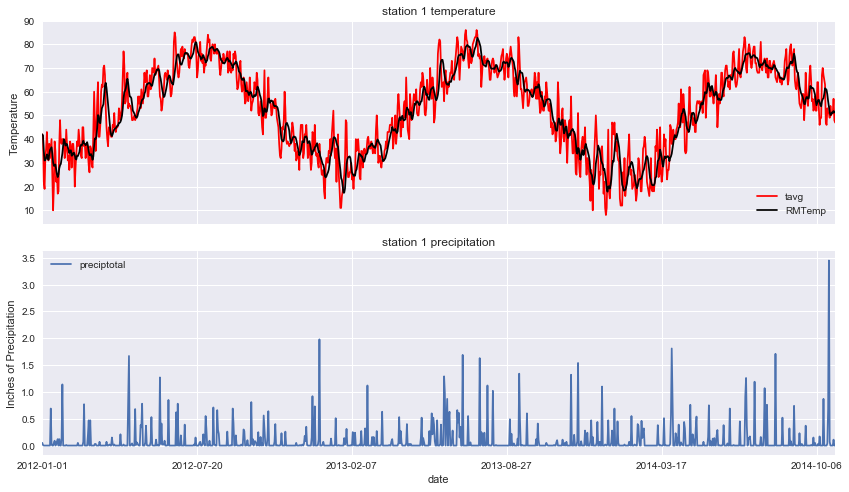

In [6]:
s1 = clean_weather.loc[weather_df.station_nbr == 1]
s1.set_index('date', inplace=True)
fig, axes = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(12,7))
s1['RMTemp'] = s1['tavg'].rolling(7, min_periods=1).mean()
s1.plot(y='tavg', ax=axes[0], title='station 1 temperature', color='red')
s1.plot(y='RMTemp', ax=axes[0], color = 'black')
axes[0].set_ylabel('Temperature')
s1.plot(y='preciptotal', ax=axes[1], title='station 1 precipitation')
axes[1].set_ylabel('Inches of Precipitation')
fig.tight_layout()
plt.show()

Using station 1 as an example for its temperature and precipitation plot, I can get an idea of what kind of weather each station is subject to. It has to be considered where these stations are generally located by their temperature patterns. This is important to think about since winter weather in colder climates is seen as standard and less likely to cause grocery store rushes, compared to winter weather in warmer climates. Also, deviations from normal temperatures of the season should also be considered. Sudden temperature changes, especially around winter time, may spur people to go to the store. Seen above, a rolling mean of the average temperature over 7 day periods was plotted on top of the average temperature plot to be able to help visualize sudden temperature changes.

In [7]:
sales_train = sales_train.replace(0, np.nan)
sales_train.dropna(inplace=True)
clean_sales = sales_train.sort_values(by = ['store_nbr', 'date'])
#clean_sales = pd.pivot_table(sales_train, values='units', index=['store_nbr', 'date'], columns=['item_nbr'])
clean_sales.head(10)

,date,store_nbr,item_nbr,units
8,2012-01-01,1,9,29.0
27,2012-01-01,1,28,2.0
50,2012-01-01,1,51,1.0
4892,2012-01-02,1,9,60.0
4911,2012-01-02,1,28,5.0
4934,2012-01-02,1,51,1.0
9776,2012-01-03,1,9,15.0
9795,2012-01-03,1,28,9.0
14660,2012-01-04,1,9,20.0
14679,2012-01-04,1,28,3.0


I've cleaned up the sales data by sorting by the store number and date respectively. I have also removed any data that shows sales of zero. I chose to do this because of the overwhelming amount of data that has zero sales, and will help derive a more concise model later. I considered using a pivot table (with its code commented out), however I had issues plotting the resulting table. Below, I will be plotting a time-series chart of sales for item 9 at store 1 for the year 2012 to see if it is a seasonal item or not.

In [8]:
s1sales = clean_sales.loc[clean_sales.store_nbr == 1]
s1_i9 = s1sales.loc[s1sales.item_nbr == 9]
mask = (s1_i9['date'] >= '2012-01-01') & (s1_i9['date'] < '2013-01-01')
s1_i9_2012 = s1_i9.loc[mask]
s1_i9_2012.head()

,date,store_nbr,item_nbr,units
8,2012-01-01,1,9,29.0
4892,2012-01-02,1,9,60.0
9776,2012-01-03,1,9,15.0
14660,2012-01-04,1,9,20.0
19544,2012-01-05,1,9,16.0


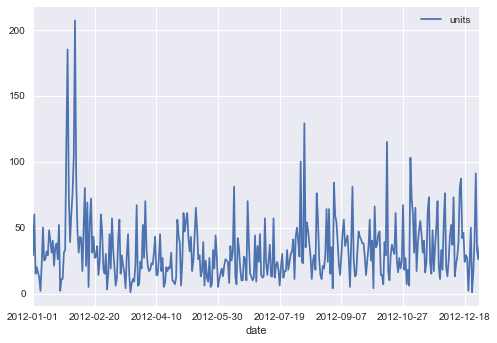

In [9]:
s1_i9_2012.plot(x='date', y='units', kind='line')
plt.show()

This particular item at store 1 seems to show relatively consistent sales, with slight increases in the fall and winter seasons. Doing the same visual analysis for other items, there are a few items that indicate a seasonal buying pattern. To quantify this, I will be finding total monthly sales, that way I can assign indicator variables for each item if it is indeed a seasonal item, which will be later utilized in the model.

In [10]:
s1sales.drop(s1sales.columns[[1]], axis=1, inplace=True)
s1sales['date'] =  pd.to_datetime(s1sales['date'])
s1sales_total_i9 = s1sales['units'].loc[s1sales.item_nbr == 9].groupby([s1sales.item_nbr, s1sales.date.dt.year, s1sales.date.dt.month]).sum()
s1sales_total_i9

/Users/vpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/vpatel/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


item_nbr  date  date
9         2012  1       1169.0
                2       1438.0
                3        733.0
                4        724.0
                5        920.0
                6        735.0
                7        750.0
                8       1183.0
                9       1125.0
                10       964.0
                11      1146.0
                12      1149.0
          2013  1       1025.0
                2       1038.0
                3       1034.0
                4        956.0
                5       1020.0
                6        424.0
                7        426.0
                8        618.0
                9        590.0
                10       933.0
                11       481.0
                12       582.0
          2014  1       1011.0
                2        735.0
                3        697.0
                4        502.0
                5        600.0
                6        510.0
                7        252.0
                8 

From the data above, it is apparent that there is not a seasonal trend for this specific item at store 1. Conducting this analysis for all other items across all stores, the following seasonal trends were discovered:
- Store 1, Item 51: Winter
- Store 1, Item 40: Winter
- Store 1, Item 93: Spring, Summer, Fall
- Store 1, Item 89: Summer and Fall
- Store 3, Item 2: Spring
- Store 4, Item 97: Winter
- Store 4, Item 96: Winter
- Store 8, Item 84: Fall
- Store 12, Item 93: Spring, Summer, Fall
- Store 13, Item 104: Winter
- Store 14, Item 50: Winter
- Store 14, Item 15: Winter
- Store 15, Item 49: Fall and Winter
- Store 15, Item 93: Summer
- Store 15, Item 15: Winter
- Store 16, Item 39: Winter
- Store 16, Item 50: Fall and Winter
- Store 19, Item 39: Winter
- Store 19, Item 93: Summer and Fall
- Store 19, Item 88: Summer and Fall
- Store 19, Item 15: Winter
- Store 24, Item 97: Winter
- Store 25, Item 50: Fall and Winter
- Store 25, Item 93: Summer
- Store 30, Item 49: Winter
- Store 35, Item 49: Winter
- Store 37, Item 15: Winter
- Store 37, Item 105: Summer
- Store 45, Item 50: Winter

Next I will merge the sales and weather data using the key dataset. This will allow me to find any relationships between sales and weather patterns.

In [11]:
sales_station = pd.merge(clean_sales, key, left_on='store_nbr', right_on='store_nbr')
sales_weather = pd.merge(sales_station, clean_weather, left_on=['date','station_nbr'], right_on=['date','station_nbr'])
sales_weather.head(10)

,date,store_nbr,item_nbr,units,station_nbr,tavg,preciptotal
0,2012-01-01,1,9,29.0,1,42,0.05
1,2012-01-01,1,28,2.0,1,42,0.05
2,2012-01-01,1,51,1.0,1,42,0.05
3,2012-01-02,1,9,60.0,1,41,0.01
4,2012-01-02,1,28,5.0,1,41,0.01
5,2012-01-02,1,51,1.0,1,41,0.01
6,2012-01-03,1,9,15.0,1,22,0.00
7,2012-01-03,1,28,9.0,1,22,0.00
8,2012-01-04,1,9,20.0,1,19,0.00
9,2012-01-04,1,28,3.0,1,19,0.00


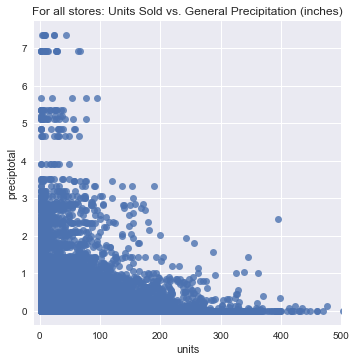

In [12]:
g = sns.lmplot(x='units', y='preciptotal', data=sales_weather, scatter=True, fit_reg=False)
g.set(xlim=(-10, 500))
plt.title('For all stores: Units Sold vs. General Precipitation (inches)')
plt.show()

In terms of a general relationship, there does not seem to be one between precipitation totals and sales of goods. To measure the influence of precipitation on sales, I will look at days where precipitation totals are more than the monthly average for precipitation.